# NLP Project 2023 : Dialog Act Recognition
Here is the code we used to create our classifiers of Dialog Act Recognition.
- dataset : dailydialog
- encoder : bert-tiny
## I - Libraries and utils
## II - Baseline : Message level classifier
## III - Dialog level classifier
 ### A. Common utils
 ### B. Classifier using the whole document as entrance
 ### C. Classifier using hierarchical Architecture of a document, and self-attention between sentences

# I - Libraries and utils
## I.1 - Libraries

In [2]:
!pip install datasets
!pip install torchvision
!pip install transformers
!pip install torchinfo
import torch
from datasets import load_dataset
from tqdm import tqdm
import nltk

from termcolor import colored
from collections import Counter

from tqdm.auto import tqdm
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchinfo import summary
import numpy as np
import os
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay 
import matplotlib.pyplot as plt
import datasets
from torch.optim import AdamW
from transformers import get_scheduler
import tensorflow as tf
from transformers import BertTokenizer,BertModel,get_scheduler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 14.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/si

## I.1 - Utils
We here define some useful variables for the rest of our study, such as our Tokenizer, the number of classes, and so on.

In [51]:
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

device = torch.device("cuda")
dailydialog = load_dataset('daily_dialog')
args=dict()
args.update({'max_dialog_length': 12,"num_classes" : 5})
args.update({'max_eps': 10, 'lr': 0.0001, 'device': device, 'cuda': -1, 'seq_len':12, 'num_class': 5})
tokenizer = BertTokenizer.from_pretrained("prajjwal1/bert-tiny")
dico_padding={'attention_mask': torch.zeros([1,64],dtype=int), 'input_ids': torch.zeros([1,64],dtype=int),'token_type_ids': torch.zeros([1,64],dtype=int)}
ebd=BertModel.from_pretrained("prajjwal1/bert-tiny")


  0%|          | 0/3 [00:00<?, ?it/s]

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Training and inference functions
We will use these functions to run each ouf our models.

In [ ]:
def train(model, optimizer, trains, ep, args):
  # set the model into a training mode : the model's weights and parameters WILL BE updated!
  model.train()
  # initialize empty lists for losses and accuracies
  loss_it, acc_it = list(), list()

  # start the loop over all the training batches. This means one full epoch.
  for it, batch in tqdm(enumerate(trains), desc="Epoch %s:" % (ep), total=trains.__len__()):
    
    # put parameters of the model and the optimizer to zero before doing another iteration
    optimizer.zero_grad()
    model.zero_grad()

    # apply the model on the batch
    loss, logits, tag_seq = model(batch)
    # compute gradient values
    loss.backward()
    # indicate to the optimizer we've done a step
    optimizer.step()
    # append the value of the loss for the current iteration (it). .item() retrieve the nuclear value as a int/long
    loss_it.append(loss.item())
    
    # Those 3 lines compute the accuracy and then append it the same way as the loss above
    correct = (tag_seq.flatten() == batch['label'].flatten()).float().sum()
    acc = correct / batch['label'].flatten().size(0)
    acc_it.append(acc.item())

  # simple averages of losses and accuracies for this epoch
  loss_it_avg = sum(loss_it)/len(loss_it)
  acc_it_avg = sum(acc_it)/len(acc_it)
  
  # print useful information about the training progress and scores on this training set's full pass (i.e. 1 epoch)
  print("Epoch %s/%s : %s : (%s %s) (%s %s)" % (colored(str(ep), 'blue'),args['max_eps'] , colored('Training', 'blue'), colored('loss', 'cyan'), sum(loss_it)/len(loss_it), colored('acc', 'cyan'), sum(acc_it) / len(acc_it)))

def inference(target, loader, model):
  """
    Args:
      target (str): modify the display, usually either 'validation' or 'test'
  """
  # set the model into a evaluation mode : the model's weights and parameters will NOT be updated!
  model.eval()

  # intialize empty list to populate later on
  loss_it, acc_it, f1_it = list(), list(), list()
  # preds = predicted values ; trues = true values .... obviously~
  preds, trues = list(), list()

  # loop over the loader batches
  for it, batch in tqdm(enumerate(loader), desc="%s:" % (target), total=loader.__len__()):
    # set an environnement without any gradient. So the tensor gradients are not considered 
    # (saves a lot of computation and memory, this is one of the many things that makes predicting far less costly than training)
    with torch.no_grad():
      # apply the model
      loss, logits, tag_seq = model(batch)
      # no need to backward() and other training stuff. Directly store the loss in the list
      loss_it.append(loss.item())
      
      # compute the accuracy and store it
      correct = (tag_seq.flatten() == batch['label'].flatten()).float().sum()
      acc = correct / batch['label'].flatten().size(0)
      acc_it.append(acc.item())
      
      # extend the predictions and true labels lists so we can compare them later on
      # note how we first ensure the tensor are on cpu (.cpu()), then we detach() the gradient from the tensor, before transforming it to a simple python list (.tolist())
      preds.extend(tag_seq.cpu().detach().tolist())
      trues.extend(batch['label'].cpu().detach().tolist())

  # compute the average loss and accuracy accross the iterations (batches)
  loss_it_avg = sum(loss_it)/len(loss_it)
  acc_it_avg = sum(acc_it)/len(acc_it)
  
  # print useful information. Important during training as we want to know the performance over the validation set after each epoch
  print("%s : (%s %s) (%s %s)" % ( colored(target, 'blue'), colored('loss', 'cyan'), sum(loss_it)/len(loss_it), colored('acc', 'cyan'), sum(acc_it) / len(acc_it)))

  # return the true and predicted values with the losses and accuracies
  return trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it

import torch.optim as optim

def run_epochs(model, args, trains, val, eval):


  # we set the optimizer as Adam with the learning rate (lr) set in the arguments
  # you can look at the different optimizer available here: https://pytorch.org/docs/stable/optim.html
  optimizer = optim.Adam(model.parameters(), lr = args['lr'])

  # define an empty list to store validation losses for each epoch
  val_ep_losses = list()
  # iterate over the number of max epochs set in the arguments
  for ep in range(args['max_eps']):
    # train the model using our defined function
    train(model, optimizer, trains, ep, args)
    # apply the model for inference using our defined function
    trues, preds, val_loss_it_avg, val_acc_it_avg, val_loss_it, val_acc_it = inference("validation", val, model)
    # append the validation losses (good losses should normally go down)
    val_ep_losses.append(val_loss_it_avg)

  # return the list of epoch validation losses in order to use it later to create a plot
  return val_ep_losses

### Here is the function used to plot our validation loss graph

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_loss(loss_list):
  '''
  this function creates a plot. a simple curve showing the different values at each steps.
  Here we use it to plot the loss so we named it plot_loss, but the same function with different titles could be used to plot accuracies
  or other metrics for instance.
  
  Args:
    loss_list (list of floats): list of numerical values
  '''
  plt.plot(range(len(loss_list)), loss_list)
  plt.xlabel('epochs')
  # in our model we use Softmax then NLLLoss which means Cross Entropy loss
  plt.ylabel('Cross Entropy')
  # in our training loop we used an Adam optimizer so we indicate it there
  plt.title('lr: {}, optim_alg:{}'.format(args['lr'], 'Adam'))
  # let's directly show the plot when calling this function
  plt.show()

## II - Baseline Prediction of our model
We work here at a message level (without taking into account the context in the dialog). Using Bert-Tiny embedding and vectorisation, we use a Neural Network of two layers after our encoding to classify our messages regarding to their labels.

### Data preparation

In [34]:
def preprocess_data_message_level(example) :
    U=[]
    L=[]
    for i in range(len(example["dialog"])) :
        for j in range(len(example["dialog"][i])) :
          tokenized=tokenizer.encode_plus(
                       example["dialog"][i][j],                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        truncation=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
          U.append(torch.mean(ebd(**tokenized)[0],1).to(device))
          L.append(example["act"][i][j])
    return {"text":U, "label" : L }
 
dailydialog_tokenized_message=datasets.DatasetDict({})
dailydialogtest_message=datasets.DatasetDict({})
for split in ["test","validation",'train']:
  dailydialogtest_message[split]=dailydialog[split]
  dailydialog_tokenized_message[split] = dailydialogtest_message[split].map(preprocess_data_message_level,remove_columns=dailydialogtest_message[split].column_names, batched=True)
  dailydialog_tokenized_message[split].set_format(type = 'torch')

train_loader_message = DataLoader(dailydialog_tokenized_message["train"], batch_size=32)
eval_loader_message = DataLoader(dailydialog_tokenized_message["validation"], batch_size=32)
val_loader_message = DataLoader(dailydialog_tokenized_message["test"], batch_size=32)  

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/11118 [00:00<?, ? examples/s]

### Message level model

In [49]:
class Classif_message_level(nn.Module):
    '''
        Here we embed each sentence of our dialog, then we average the embedding for each sentence. Data is a dialog (list of sentences) and labels (list of labels).
        In the end we have a tensor of shape 12*768 (max_dialog*length)
    '''
    def __init__(self,args):
        super(Classif_message_level, self).__init__()
        self.args=args
        self.layer1 = torch.nn.Linear(128,100)
        # instanciate a dropout layer with 0.5. This means, we will ignore (put to zeros) half (0.5) of the data to prevent the model from overfitting
        #self.drop = nn.Dropout(p=0.5)

        # instanciate a linear layer with an output size equal to the number of classes. This means this will be used to apply a criterion to compute the predictions.
        self.layer2 = torch.nn.Linear(100, args["num_classes"])      

    def forward(self, data):
        '''
            @param data dictionary
                @key text: batch_size * max_text_len
            @return output: batch_size * embedding_dim
        '''
        output=self.layer1(data["text"])
        #output = self.drop(output)
        outputs=self.layer2(output)
        
        batch_size = outputs.size(0)
        seq_len = outputs.size(1)

        # modify the outputs representation to prepare score computation
        outputs = outputs.view(batch_size*seq_len, -1)
        # apply a softmax on the outputs to obtain probabilities
        scores = F.log_softmax(outputs, 1)

        # get the predicted tags using the maximum probability from the softmax
        _, tag_seq  = torch.max(scores, 1)
        # reshape the predicted tags to follow the batch and sequence length
        tag_seq = tag_seq.view(batch_size, seq_len)

        # some example of manual class weights
        # weights = torch.Tensor([0.1, 1, 1, 1, 1, 1, 1]).to(device)

        
        if 'class_weights' in self.args:
          # class weights from args if there is any. It should be a torch tensor, but we move it to the dedicated device
          # we use class weights to influence the Negative Log Likelihood. Influencing in the same time the backpropagation and, thus, the update of the model
          loss_fn = nn.NLLLoss(weight=self.args['class_weights'].to(device))  
        else: 
          # if not 'class_weights' key in the args dict(), we use the Negative Log Likelihood as is
          loss_fn = nn.NLLLoss()

        # apply the loss function (Softmax + NLLLoss = Cross Entropy)
        loss = loss_fn(scores, data['label'].view(batch_size*seq_len))

        # we return 3 elements as a tuple : the loss, the softmax outputs, and the predicted tag set already in a good format
        return loss, scores, tag_seq

In [82]:
model=Classif_message_level(args).to(device)
loss_list_val = run_epochs(model, args, train_loader_message, val_loader_message,eval_loader_message)

Epoch 0::   0%|          | 0/2725 [00:00<?, ?it/s]

Epoch 0/10 : Training : (loss 0.7533778242397746) (acc 0.7199197247706423)


validation::   0%|          | 0/242 [00:00<?, ?it/s]

validation : (loss 0.6908871727295158) (acc 0.7333788371775761)


Epoch 1::   0%|          | 0/2725 [00:00<?, ?it/s]

Epoch 1/10 : Training : (loss 0.6664683428543423) (acc 0.7437155963302752)


validation::   0%|          | 0/242 [00:00<?, ?it/s]

validation : (loss 0.6739347764283172) (acc 0.7407578217589166)


Epoch 2::   0%|          | 0/2725 [00:00<?, ?it/s]

Epoch 2/10 : Training : (loss 0.6564371587431759) (acc 0.747545871559633)


validation::   0%|          | 0/242 [00:00<?, ?it/s]

validation : (loss 0.6672065472307284) (acc 0.7406286895275116)


Epoch 3::   0%|          | 0/2725 [00:00<?, ?it/s]

Epoch 3/10 : Training : (loss 0.651687108961814) (acc 0.7490711009174312)


validation::   0%|          | 0/242 [00:00<?, ?it/s]

validation : (loss 0.6634526746578453) (acc 0.7415326151473463)


Epoch 4::   0%|          | 0/2725 [00:00<?, ?it/s]

Epoch 4/10 : Training : (loss 0.6488752922880541) (acc 0.7500229357798165)


validation::   0%|          | 0/242 [00:00<?, ?it/s]

validation : (loss 0.6610059657495869) (acc 0.7411267710618736)


Epoch 5::   0%|          | 0/2725 [00:00<?, ?it/s]

Epoch 5/10 : Training : (loss 0.6469800545124833) (acc 0.7504128440366973)


validation::   0%|          | 0/242 [00:00<?, ?it/s]

validation : (loss 0.6592446191251771) (acc 0.7428054900701381)


Epoch 6::   0%|          | 0/2725 [00:00<?, ?it/s]

Epoch 6/10 : Training : (loss 0.6455821181656024) (acc 0.7510894495412844)


validation::   0%|          | 0/242 [00:00<?, ?it/s]

validation : (loss 0.6578861793333833) (acc 0.7429346223015431)


Epoch 7::   0%|          | 0/2725 [00:00<?, ?it/s]

Epoch 7/10 : Training : (loss 0.6444828713678439) (acc 0.7515481651376147)


validation::   0%|          | 0/242 [00:00<?, ?it/s]

validation : (loss 0.6567856885554376) (acc 0.7434511512271629)


Epoch 8::   0%|          | 0/2725 [00:00<?, ?it/s]

Epoch 8/10 : Training : (loss 0.6435781374382317) (acc 0.7520871559633028)


validation::   0%|          | 0/242 [00:00<?, ?it/s]

validation : (loss 0.6558616253709005) (acc 0.7453881346982373)


Epoch 9::   0%|          | 0/2725 [00:00<?, ?it/s]

Epoch 9/10 : Training : (loss 0.6428086150950248) (acc 0.752144495412844)


validation::   0%|          | 0/242 [00:00<?, ?it/s]

validation : (loss 0.655064632146319) (acc 0.7456463991610471)


test::   0%|          | 0/32 [00:00<?, ?it/s]

test : (loss 1.1586767360568047) (acc 0.4505208348855376)


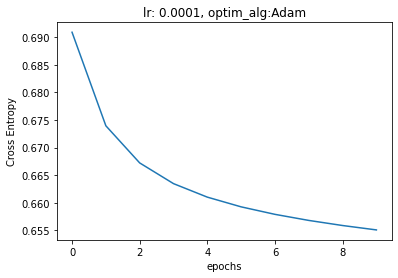

              precision    recall  f1-score   support

      inform       0.32      0.88      0.47      2948
    question       0.84      0.88      0.86      2175
   directive       0.59      0.48      0.53      1705
  commissive       0.49      0.08      0.14       867

   micro avg       0.45      0.70      0.55      7695
   macro avg       0.56      0.58      0.50      7695
weighted avg       0.54      0.70      0.55      7695



In [84]:
trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it = inference("test", eval_loader, model)
plot_loss(loss_list_val)
names = [ 'inform', 'question', 'directive', 'commissive']
print(classification_report(np.array(trues).flatten(), np.array(preds).flatten(), target_names=names, labels=[1, 2, 3, 4]))

## III - Dialog level prediction
### III.A Common utils
From now, we are working at a dialog level classification. We will use a common preprocess for data.

In [64]:

def preprocess_data_dialog_level(example) :
  L=[]
  N=min(12,len(example["dialog"]))
  U=example["act"][:N]
  for i in range(N) :
    tokenized=tokenizer.encode_plus(
                       example["dialog"][i],                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        truncation=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    L.append(torch.mean(ebd(**tokenized)[0],1))
  for i in range(12-N) :
    L.append(torch.zeros(1,128))
    U.append(0)
  res=torch.squeeze(torch.stack(L))
  return( {'text': res, "label" : torch.tensor(U) })

dailydialog_tokenized=datasets.DatasetDict({})
dailydialogtest=datasets.DatasetDict({})
for split in ["test","validation",'train']:
  dailydialogtest[split]=dailydialog[split]
  dailydialog_tokenized[split] = dailydialogtest[split].map(preprocess_data_dialog_level)
  dailydialog_tokenized[split] = dailydialog_tokenized[split].remove_columns(["dialog","act","emotion"])
  dailydialog_tokenized[split].set_format(type = 'torch')

train_loader = DataLoader(dailydialog_tokenized["train"], batch_size=32)
eval_loader = DataLoader(dailydialog_tokenized["validation"], batch_size=32)
val_loader = DataLoader(dailydialog_tokenized["test"], batch_size=32)  


args.update({'max_eps': 10, 'lr': 0.0001, 'device': 'cpu', 'cuda': -1, 'seq_len':12, 'num_class': 5})

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/11118 [00:00<?, ? examples/s]

### III.B - Linear Dialog Level Classifier

In [66]:
class Classif_dialog_level(nn.Module):
    '''
        Here we embed each sentence of our dialog, then we average the embedding for each sentence. Data is a dialog (list of sentences) and labels (list of labels).
        In the end we have a tensor of shape 12*768 (max_dialog*length)
    '''
    def __init__(self,args):
        super(Classif_dialog_level, self).__init__()
        self.args=args
        self.layer1 = torch.nn.Linear(128,100)
        # instanciate a dropout layer with 0.5. This means, we will ignore (put to zeros) half (0.5) of the data to prevent the model from overfitting
        #self.drop = nn.Dropout(p=0.5)

        # instanciate a linear layer with an output size equal to the number of classes. This means this will be used to apply a criterion to compute the predictions.
        self.layer2 = torch.nn.Linear(100, args["num_classes"])      

    def forward(self, data):
        '''
            @param data dictionary
                @key text: batch_size * max_text_len
            @return output: batch_size * embedding_dim
        '''
        output=self.layer1(data["text"])
        #output = self.drop(output)
        outputs=self.layer2(output)
        
        batch_size = outputs.size(0)
        seq_len = outputs.size(1)

        # modify the outputs representation to prepare score computation
        outputs = outputs.view(batch_size*seq_len, -1)
        # apply a softmax on the outputs to obtain probabilities
        scores = F.log_softmax(outputs, 1)

        # get the predicted tags using the maximum probability from the softmax
        _, tag_seq  = torch.max(scores, 1)
        # reshape the predicted tags to follow the batch and sequence length
        tag_seq = tag_seq.view(batch_size, seq_len)

        # some example of manual class weights
        # weights = torch.Tensor([0.1, 1, 1, 1, 1, 1, 1]).to(device)

        
        if 'class_weights' in self.args:
          # class weights from args if there is any. It should be a torch tensor, but we move it to the dedicated device
          # we use class weights to influence the Negative Log Likelihood. Influencing in the same time the backpropagation and, thus, the update of the model
          loss_fn = nn.NLLLoss(weight=self.args['class_weights'].to(device))  
        else: 
          # if not 'class_weights' key in the args dict(), we use the Negative Log Likelihood as is
          loss_fn = nn.NLLLoss()

        # apply the loss function (Softmax + NLLLoss = Cross Entropy)
        loss = loss_fn(scores, data['label'].view(batch_size*seq_len))

        # we return 3 elements as a tuple : the loss, the softmax outputs, and the predicted tag set already in a good format
        return loss, scores, tag_seq

In [80]:
model=Classif_dialog_level(args).to(device)


loss_list_val = run_epochs(model, args, train_loader, val_loader, eval_loader)

Epoch 0::   0%|          | 0/348 [00:00<?, ?it/s]

Epoch 0/10 : Training : (loss 1.2453016347583683) (acc 0.5719748486379355)


validation::   0%|          | 0/32 [00:00<?, ?it/s]

validation : (loss 1.0326429065316916) (acc 0.8273112010210752)


Epoch 1::   0%|          | 0/348 [00:00<?, ?it/s]

Epoch 1/10 : Training : (loss 0.8879711669066856) (acc 0.8286402734189198)


validation::   0%|          | 0/32 [00:00<?, ?it/s]

validation : (loss 0.7747102025896311) (acc 0.8356119841337204)


Epoch 2::   0%|          | 0/348 [00:00<?, ?it/s]

Epoch 2/10 : Training : (loss 0.6651941417962656) (acc 0.8349764395034176)


validation::   0%|          | 0/32 [00:00<?, ?it/s]

validation : (loss 0.5831869933754206) (acc 0.838704427704215)


Epoch 3::   0%|          | 0/348 [00:00<?, ?it/s]

Epoch 3/10 : Training : (loss 0.527400279867238) (acc 0.8377879962496374)


validation::   0%|          | 0/32 [00:00<?, ?it/s]

validation : (loss 0.48960407357662916) (acc 0.8421224001795053)


Epoch 4::   0%|          | 0/348 [00:00<?, ?it/s]

Epoch 4/10 : Training : (loss 0.46641196481797886) (acc 0.8399399613169418)


validation::   0%|          | 0/32 [00:00<?, ?it/s]

validation : (loss 0.4501691199839115) (acc 0.8422851525247097)


Epoch 5::   0%|          | 0/348 [00:00<?, ?it/s]

Epoch 5/10 : Training : (loss 0.439644569466854) (acc 0.8411821801772063)


validation::   0%|          | 0/32 [00:00<?, ?it/s]

validation : (loss 0.4314645449630916) (acc 0.8450520858168602)


Epoch 6::   0%|          | 0/348 [00:00<?, ?it/s]

Epoch 6/10 : Training : (loss 0.4260822303336242) (acc 0.8425740632175029)


validation::   0%|          | 0/32 [00:00<?, ?it/s]

validation : (loss 0.42120341677218676) (acc 0.844319662079215)


Epoch 7::   0%|          | 0/348 [00:00<?, ?it/s]

Epoch 7/10 : Training : (loss 0.41823192959886857) (acc 0.8434966394956085)


validation::   0%|          | 0/32 [00:00<?, ?it/s]

validation : (loss 0.4149062177166343) (acc 0.8442382868379354)


Epoch 8::   0%|          | 0/348 [00:00<?, ?it/s]

Epoch 8/10 : Training : (loss 0.4132215137454285) (acc 0.8444170772001661)


validation::   0%|          | 0/32 [00:00<?, ?it/s]

validation : (loss 0.41071515111252666) (acc 0.8436686173081398)


Epoch 9::   0%|          | 0/348 [00:00<?, ?it/s]

Epoch 9/10 : Training : (loss 0.4097909240116333) (acc 0.8449505252399664)


validation::   0%|          | 0/32 [00:00<?, ?it/s]

validation : (loss 0.40775542240589857) (acc 0.8451334685087204)


test::   0%|          | 0/32 [00:00<?, ?it/s]

test : (loss 0.48599379137158394) (acc 0.8054199181497097)


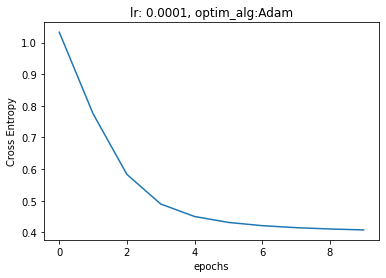

              precision    recall  f1-score   support

      inform       0.66      0.88      0.76      2948
    question       0.82      0.91      0.86      2175
   directive       0.58      0.43      0.50      1705
  commissive       0.46      0.06      0.10       867

   micro avg       0.70      0.70      0.70      7695
   macro avg       0.63      0.57      0.55      7695
weighted avg       0.67      0.70      0.66      7695



In [81]:
trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it = inference("test", eval_loader, model)
plot_loss(loss_list_val)
names = [ 'inform', 'question', 'directive', 'commissive']
print(classification_report(np.array(trues).flatten(), np.array(preds).flatten(), target_names=names, labels=[1, 2, 3, 4]))

## IV - BiLTSM Model for prediction
We fine-tune our bert encoder using a Recursive Neural Network, taking into account relations between sentences of a dialog.

In [74]:
class Classif_cours_model(nn.Module):
    '''
        Here we embed each sentence of our dialog, then we average the embedding for each sentence. Data is a dialog (list of sentences) and labels (list of labels).
        In the end we have a tensor of shape 12*768 (max_dialog*length)
    '''
    def __init__(self,args,dimension=50):
        super(Classif_cours_model, self).__init__()
        self.args=args
        self.lstm = nn.LSTM(input_size=128,
                            hidden_size=dimension//2, 
                            num_layers=3,
                            batch_first=True,
                            bidirectional=True)
        self.dimension = dimension
        # instanciate a dropout layer with 0.5. This means, we will ignore (put to zeros) half (0.5) of the data to prevent the model from overfitting
        #self.drop = nn.Dropout(p=0.5)

        # instanciate a linear layer with an output size equal to the number of classes. This means this will be used to apply a criterion to compute the predictions.
        self.hidden2tag = torch.nn.Linear(dimension, args["num_classes"])
        self.softmax = nn.Softmax(dim=1)       

    def forward(self, data):
        '''
            @param data dictionary
                @key text: batch_size * max_text_len
            @return output: batch_size * embedding_dim
        '''
        output,hidden=self.lstm(data["text"])
        #output = self.drop(output)
        outputs=self.hidden2tag(output)
        
        batch_size = outputs.size(0)
        seq_len = outputs.size(1)

        # modify the outputs representation to prepare score computation
        outputs = outputs.view(batch_size*seq_len, -1)
        # apply a softmax on the outputs to obtain probabilities
        scores = F.log_softmax(outputs, 1)

        # get the predicted tags using the maximum probability from the softmax
        _, tag_seq  = torch.max(scores, 1)
        # reshape the predicted tags to follow the batch and sequence length
        tag_seq = tag_seq.view(batch_size, seq_len)

        # some example of manual class weights
        # weights = torch.Tensor([0.1, 1, 1, 1, 1, 1, 1]).to(device)

        
        if 'class_weights' in self.args:
          # class weights from args if there is any. It should be a torch tensor, but we move it to the dedicated device
          # we use class weights to influence the Negative Log Likelihood. Influencing in the same time the backpropagation and, thus, the update of the model
          loss_fn = nn.NLLLoss(weight=self.args['class_weights'].to(device))  
        else: 
          # if not 'class_weights' key in the args dict(), we use the Negative Log Likelihood as is
          loss_fn = nn.NLLLoss()

        # apply the loss function (Softmax + NLLLoss = Cross Entropy)
        loss = loss_fn(scores, data['label'].view(batch_size*seq_len))

        # we return 3 elements as a tuple : the loss, the softmax outputs, and the predicted tag set already in a good format
        return loss, scores, tag_seq



In [75]:
model=Classif_cours_model(args).to(device)

loss_list_val = run_epochs(model, args, train_loader, val_loader, eval_loader)

Epoch 0::   0%|          | 0/348 [00:00<?, ?it/s]

Epoch 0/10 : Training : (loss 1.2705793945953763) (acc 0.5133650629599203)


validation::   0%|          | 0/32 [00:00<?, ?it/s]

validation : (loss 0.8615227248519659) (acc 0.6690266914665699)


Epoch 1::   0%|          | 0/348 [00:00<?, ?it/s]

Epoch 1/10 : Training : (loss 0.7902232884675607) (acc 0.6812557739087906)


validation::   0%|          | 0/32 [00:00<?, ?it/s]

validation : (loss 0.7581579871475697) (acc 0.6842447929084301)


Epoch 2::   0%|          | 0/348 [00:00<?, ?it/s]

Epoch 2/10 : Training : (loss 0.7292002519999428) (acc 0.7018699550080574)


validation::   0%|          | 0/32 [00:00<?, ?it/s]

validation : (loss 0.6997780669480562) (acc 0.732666015625)


Epoch 3::   0%|          | 0/348 [00:00<?, ?it/s]

Epoch 3/10 : Training : (loss 0.6174893007538784) (acc 0.7926095556253674)


validation::   0%|          | 0/32 [00:00<?, ?it/s]

validation : (loss 0.5376861849799752) (acc 0.8256022110581398)


Epoch 4::   0%|          | 0/348 [00:00<?, ?it/s]

Epoch 4/10 : Training : (loss 0.4999034205216101) (acc 0.8256982943449898)


validation::   0%|          | 0/32 [00:00<?, ?it/s]

validation : (loss 0.4832435632124543) (acc 0.8299153633415699)


Epoch 5::   0%|          | 0/348 [00:00<?, ?it/s]

Epoch 5/10 : Training : (loss 0.4669042693815012) (acc 0.8300685043307556)


validation::   0%|          | 0/32 [00:00<?, ?it/s]

validation : (loss 0.4605294978246093) (acc 0.8337402306497097)


Epoch 6::   0%|          | 0/348 [00:00<?, ?it/s]

Epoch 6/10 : Training : (loss 0.44644247620612726) (acc 0.8346525218294955)


validation::   0%|          | 0/32 [00:00<?, ?it/s]

validation : (loss 0.4389862515963614) (acc 0.8370768260210752)


Epoch 7::   0%|          | 0/348 [00:00<?, ?it/s]

Epoch 7/10 : Training : (loss 0.4283288546848571) (acc 0.8386998829142801)


validation::   0%|          | 0/32 [00:00<?, ?it/s]

validation : (loss 0.41940066358074546) (acc 0.841796875)


Epoch 8::   0%|          | 0/348 [00:00<?, ?it/s]

Epoch 8/10 : Training : (loss 0.41427134067333976) (acc 0.8417893913628041)


validation::   0%|          | 0/32 [00:00<?, ?it/s]

validation : (loss 0.4071539188735187) (acc 0.8453776054084301)


Epoch 9::   0%|          | 0/348 [00:00<?, ?it/s]

Epoch 9/10 : Training : (loss 0.40343839957796296) (acc 0.8446907507277083)


validation::   0%|          | 0/32 [00:00<?, ?it/s]

validation : (loss 0.3982013687491417) (acc 0.8465169258415699)


test::   0%|          | 0/32 [00:00<?, ?it/s]

test : (loss 0.47751162201166153) (acc 0.804443359375)


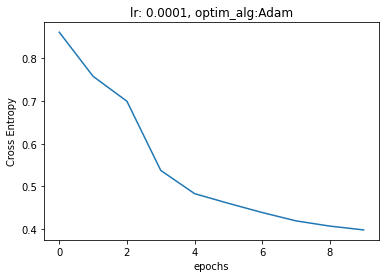

              precision    recall  f1-score   support

      inform       0.67      0.89      0.76      2948
    question       0.81      0.92      0.86      2175
   directive       0.57      0.41      0.48      1705
  commissive       0.51      0.03      0.06       867

   micro avg       0.70      0.70      0.70      7695
   macro avg       0.64      0.56      0.54      7695
weighted avg       0.67      0.70      0.65      7695



In [79]:
trues, preds, loss_it_avg, acc_it_avg, loss_it, acc_it = inference("test", eval_loader, model)
plot_loss(loss_list_val)
names = [ 'inform', 'question', 'directive', 'commissive']
print(classification_report(np.array(trues).flatten(), np.array(preds).flatten(), target_names=names, labels=[1, 2, 3, 4]))

<BarContainer object of 4 artists>

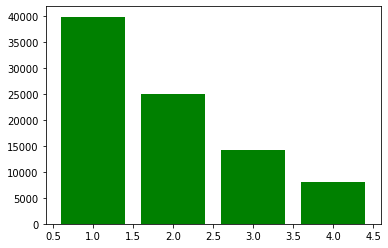

In [94]:
L=[el for sublist in dailydialog["train"]["act"] for el in sublist] 
dico=Counter(L)
plt.bar(dico.keys(), dico.values(), color='g')